<a href="https://colab.research.google.com/github/sanjanascorner/neural-architecture-search/blob/master/colabNAS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip uninstall -y numpy
!pip install numpy==1.26.4


Found existing installation: numpy 1.26.4
Uninstalling numpy-1.26.4:
  Successfully uninstalled numpy-1.26.4
  Using cached numpy-1.26.4-cp312-cp312-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (61 kB)
Using cached numpy-1.26.4-cp312-cp312-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (18.0 MB)
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
shap 0.50.0 requires numpy>=2, but you have numpy 1.26.4 which is incompatible.
opencv-python 4.13.0.92 requires numpy>=2; python_version >= "3.9", but you have numpy 1.26.4 which is incompatible.
rasterio 1.5.0 requires numpy>=2, but you have numpy 1.26.4 which is incompatible.
pytensor 2.37.0 requires numpy>=2.0, but you have numpy 1.26.4 which is incompatible.
tobler 0.13.0 requires numpy>=2.0, but you have numpy 1.26.4 which is incompatible.
opencv-python-headless 4.13.0.92 requires numpy>=2; python_version 

In [ ]:
!pip install -q tensorflow-model-optimization

In [ ]:

!chmod +x stm32tflm

In [16]:

from tensorflow_model_optimization.python.core.keras.compat import keras
from pathlib import Path
import tensorflow as tf
import numpy as np
import subprocess
import datetime
import shutil
import glob
import re
import os

class ColabNAS :
    architecture_name = 'resulting_architecture'
    def __init__(self, max_RAM, max_Flash, max_MACC, path_to_training_set, val_split, cache=False, input_shape=(50,50,3), save_path='.', path_to_stm32tflm='/content/stm32tflm') :
        self.learning_rate = 1e-3
        self.batch_size = 128
        self.epochs = 100 #minimum 2

        self.max_MACC = max_MACC
        self.max_Flash = max_Flash
        self.max_RAM = max_RAM
        self.path_to_training_set = path_to_training_set
        self.num_classes = len(next(os.walk(path_to_training_set))[1])
        self.val_split = val_split
        self.cache = cache
        self.input_shape = input_shape
        self.save_path = Path(save_path)

        self.path_to_trained_models = self.save_path / "trained_models"
        self.path_to_trained_models.mkdir(parents=True)

        self.path_to_stm32tflm = Path(path_to_stm32tflm)

        self.load_training_set()

    # k number of kernels of the first convolutional layer
    # c number of cells added upon the first convolutional layer
    # pre-processing pipeline not included in MACC computation
    def Model(self, k, c) :
        kernel_size = (3,3)
        pool_size = (2,2)
        pool_strides = (2,2)

        number_of_cells_limited = False
        number_of_mac = 0

        inputs = keras.Input(shape=self.input_shape)

        #convolutional base
        n = int(k)
        multiplier = 2

        #first convolutional layer
        c_in = self.input_shape[2]
        x = keras.layers.Conv2D(n, kernel_size, padding='same')(inputs)
        x = keras.layers.BatchNormalization()(x)
        x = keras.layers.ReLU()(x)

        number_of_mac = number_of_mac + (c_in * kernel_size[0] * kernel_size[1] * x.shape[1] * x.shape[2] * x.shape[3])

        #adding cells
        for i in range(1, c + 1) :
            if x.shape[1] <= 1 or x.shape[2] <= 1 :
                number_of_cells_limited = True
                break;
            n = int(np.ceil(n * multiplier))
            multiplier = multiplier - 2**-i
            x = keras.layers.MaxPooling2D(pool_size=pool_size, strides=pool_strides, padding='valid')(x)
            c_in = x.shape[3]
            x = keras.layers.Conv2D(n, kernel_size, padding='same')(x)
            x = keras.layers.BatchNormalization()(x)
            x = keras.layers.ReLU()(x)
            number_of_mac = number_of_mac + (c_in * kernel_size[0] * kernel_size[1] * x.shape[1] * x.shape[2] * x.shape[3])

        #classifier
        x = keras.layers.GlobalAveragePooling2D()(x)
        input_shape = x.shape[1]
        x = keras.layers.Dense(n)(x)
        x = keras.layers.BatchNormalization()(x)
        x = keras.layers.ReLU()(x)
        number_of_mac = number_of_mac + (input_shape * x.shape[1])
        x = keras.layers.Dense(self.num_classes)(x)
        x = keras.layers.BatchNormalization()(x)
        outputs = keras.layers.Softmax()(x)
        number_of_mac = number_of_mac + (x.shape[1] * outputs.shape[1])

        model = keras.Model(inputs=inputs, outputs=outputs)

        opt = tf.keras.optimizers.Adam(learning_rate=self.learning_rate)
        model.compile(optimizer=opt,
                loss='categorical_crossentropy',
                metrics=['accuracy'])

        model.summary()

        return model, number_of_mac, number_of_cells_limited

    def load_training_set(self):
        if 3 == self.input_shape[2] :
            color_mode = 'rgb'
        elif 1 == self.input_shape[2] :
            color_mode = 'grayscale'

        train_ds = tf.keras.utils.image_dataset_from_directory(
            directory= self.path_to_training_set,
            labels='inferred',
            label_mode='categorical',
            color_mode=color_mode,
            batch_size=self.batch_size,
            image_size=self.input_shape[0:2],
            shuffle=True,
            seed=11,
            validation_split=self.val_split,
            subset='training'
        )

        validation_ds = tf.keras.utils.image_dataset_from_directory(
            directory= self.path_to_training_set,
            labels='inferred',
            label_mode='categorical',
            color_mode=color_mode,
            batch_size=self.batch_size,
            image_size=self.input_shape[0:2],
            shuffle=True,
            seed=11,
            validation_split=self.val_split,
            subset='validation'
        )

        data_augmentation = tf.keras.Sequential([
            tf.keras.layers.RandomFlip("horizontal"),
            tf.keras.layers.RandomRotation(0.2, fill_mode='constant', interpolation='bilinear'),
            #tf.keras.layers.Rescaling(1./255)
            ])

        if self.cache :
            self.train_ds = train_ds.map(lambda x, y: (data_augmentation(x, training=True), y), num_parallel_calls=tf.data.AUTOTUNE).cache().prefetch(buffer_size=tf.data.AUTOTUNE)
            self.validation_ds = validation_ds.cache().prefetch(buffer_size=tf.data.AUTOTUNE)
        else :
            self.train_ds = train_ds.map(lambda x, y: (data_augmentation(x, training=True), y), num_parallel_calls=tf.data.AUTOTUNE).prefetch(buffer_size=tf.data.AUTOTUNE)
            self.validation_ds = validation_ds.prefetch(buffer_size=tf.data.AUTOTUNE)

    def quantize_model_uint8(self) :
        def representative_dataset():
            for data in self.train_ds.rebatch(1).take(150) :
                yield [tf.dtypes.cast(data[0], tf.float32)]

        model = tf.keras.models.load_model(self.path_to_trained_models / f"{self.model_name}.h5")
        converter = tf.lite.TFLiteConverter.from_keras_model(model)
        converter.optimizations = [tf.lite.Optimize.DEFAULT]
        converter.representative_dataset = representative_dataset
        converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
        converter.inference_input_type = tf.uint8
        converter.inference_output_type = tf.uint8
        tflite_quant_model = converter.convert()

        with open(self.path_to_trained_models / f"{self.model_name}.tflite", 'wb') as f:
            f.write(tflite_quant_model)

        (self.path_to_trained_models / f"{self.model_name}.h5").unlink()

    def evaluate_flash_and_peak_RAM_occupancy(self) :
        #quantize model to evaluate its peak RAM occupancy and its Flash occupancy
        self.quantize_model_uint8()

        #evaluate its peak RAM occupancy and its Flash occupancy using STMicroelectronics' X-CUBE-AI
        proc = subprocess.Popen([self.path_to_stm32tflm, self.path_to_trained_models / f"{self.model_name}.tflite"], stdout=subprocess.PIPE)
        try:
            outs, errs = proc.communicate(timeout=15)
            Flash, RAM = re.findall(r'\d+', str(outs))
        except subprocess.TimeoutExpired:
            proc.kill()
            outs, errs = proc.communicate()
            print("stm32tflm error")
            exit()

        return int(Flash), int(RAM)

    def evaluate_model_process(self, k, c) :
        if k > 0 :
            self.model_name = f"k_{k}_c_{c}"
            print(f"\n{self.model_name}\n")
            checkpoint = tf.keras.callbacks.ModelCheckpoint(
                str(self.path_to_trained_models / f"{self.model_name}.h5"), monitor='val_accuracy',
                verbose=1, save_best_only=True, save_weights_only=False, mode='auto')
            model, MACC, number_of_cells_limited = self.Model(k, c)
            #One epoch of training must be done before quantization, which is needed to evaluate RAM and Flash occupancy
            model.fit(self.train_ds, epochs=1, validation_data=self.validation_ds, validation_freq=1)
            model.save(self.path_to_trained_models / f"{self.model_name}.h5")
            Flash, RAM = self.evaluate_flash_and_peak_RAM_occupancy()
            print(f"\nRAM: {RAM},\t Flash: {Flash},\t MACC: {MACC}\n")
            if MACC <= self.max_MACC and Flash <= self.max_Flash and RAM <= self.max_RAM and not number_of_cells_limited :
                hist = model.fit(self.train_ds, epochs=self.epochs - 1, validation_data=self.validation_ds, validation_freq=1, callbacks=[checkpoint])
                self.quantize_model_uint8()
            return {'k': k,
                    'c': c if not number_of_cells_limited else "Not feasible",
                    'RAM': RAM if RAM <= self.max_RAM else "Outside the upper bound",
                    'Flash': Flash if Flash <= self.max_Flash else "Outside the upper bound",
                    'MACC': MACC if MACC <= self.max_MACC else "Outside the upper bound",
                    'max_val_acc':
                    np.around(np.amax(hist.history['val_accuracy']), decimals=3)
                    if 'hist' in locals() else -3}
        else :
            return{'k': 'unfeasible', 'c': c, 'max_val_acc': -3}

    def explore_num_cells(self, k) :
        previous_architecture = {'k': -1, 'c': -1, 'max_val_acc': -2}
        current_architecture = {'k': -1, 'c': -1, 'max_val_acc': -1}
        c = -1
        k = int(k)

        while(current_architecture['max_val_acc'] > previous_architecture['max_val_acc']) :
            previous_architecture = current_architecture
            c = c + 1
            self.model_counter = self.model_counter + 1
            current_architecture = self.evaluate_model_process(k, c)
            print(f"\n\n\n{current_architecture}\n\n\n")
        return previous_architecture

    def search(self) :
        self.model_counter = 0
        epsilon = 0.005
        k0 = 4

        start = datetime.datetime.now()

        k = k0
        previous_architecture = self.explore_num_cells(k)
        k = 2 * k
        current_architecture = self.explore_num_cells(k)

        if (current_architecture['max_val_acc'] > previous_architecture['max_val_acc']) :
            previous_architecture = current_architecture
            k = 2 * k
            current_architecture = self.explore_num_cells(k)
            while(current_architecture['max_val_acc'] > previous_architecture['max_val_acc'] + epsilon) :
                previous_architecture = current_architecture
                k = 2 * k
                current_architecture = self.explore_num_cells(k)
        else :
            k = k0 / 2
            current_architecture = self.explore_num_cells(k)
            while(current_architecture['max_val_acc'] >= previous_architecture['max_val_acc']) :
                previous_architecture = current_architecture
                k = k / 2
                current_architecture = self.explore_num_cells(k)

        resulting_architecture = previous_architecture

        end = datetime.datetime.now()

        if (resulting_architecture['max_val_acc'] > 0) :
            resulting_architecture_name = f"k_{resulting_architecture['k']}_c_{resulting_architecture['c']}.tflite"
            self.path_to_resulting_architecture = self.save_path / f"resulting_architecture_{resulting_architecture_name}"
            (self.path_to_trained_models / f"{resulting_architecture_name}").rename(self.path_to_resulting_architecture)
            shutil.rmtree(self.path_to_trained_models)
            print(f"\nResulting architecture: {resulting_architecture}\n")
        else :
            print(f"\nNo feasible architecture found\n")
        print(f"Elapsed time (search): {end-start}\n")

        return self.path_to_resulting_architecture


In [17]:
dataset_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz"
data_dir = tf.keras.utils.get_file('flower_photos.tar', origin=dataset_url, extract=True)
data_dir = Path(data_dir).with_suffix('')

In [ ]:
import numpy as np
import tensorflow as tf

input_shape = (50,50,3)

#target: STM32L412KBU3
#273 CoreMark, 40 kiB RAM, 128 kiB Flash
peak_RAM_upper_bound = 40960
Flash_upper_bound = 131072
MACC_upper_bound = 2730000 #CoreMark * 1e4

#Each dataset must comply with the following structure
#main_directory/
#...class_a/
#......a_image_1.jpg
#......a_image_2.jpg
#...class_b/
#......b_image_1.jpg
#......b_image_2.jpg
path_to_training_set = data_dir
val_split = 0.3

#whether or not to cache datasets in memory
#if the dataset cannot fit in the main memory, the application will crash
cache = True

#where to save results
save_path = '/content/'

#to show the GPU used
!nvidia-smi

colabNAS = ColabNAS(peak_RAM_upper_bound, Flash_upper_bound, MACC_upper_bound, path_to_training_set, val_split, cache, input_shape, save_path=save_path)

#search
path_to_tflite_model = colabNAS.search()

In [23]:
dataset_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz"
data_dir = tf.keras.utils.get_file('flower_photos.tar', origin=dataset_url, extract=True)
data_dir = Path(data_dir).with_suffix('')

In [ ]:
import numpy as np
import tensorflow as tf

input_shape = (50,50,3)

#target: STM32L412KBU3
#273 CoreMark, 40 kiB RAM, 128 kiB Flash
peak_RAM_upper_bound = 40960
Flash_upper_bound = 131072
MACC_upper_bound = 2730000 #CoreMark * 1e4

#Each dataset must comply with the following structure
#main_directory/
#...class_a/
#......a_image_1.jpg
#......a_image_2.jpg
#...class_b/
#......b_image_1.jpg
#......b_image_2.jpg
path_to_training_set = data_dir
val_split = 0.3

#whether or not to cache datasets in memory
#if the dataset cannot fit in the main memory, the application will crash
cache = True

#where to save results
save_path = '/content/'

#to show the GPU used
!nvidia-smi

colabNAS = ColabNAS(peak_RAM_upper_bound, Flash_upper_bound, MACC_upper_bound, path_to_training_set, val_split, cache, input_shape, save_path=save_path)

#search
path_to_tflite_model = colabNAS.search()


/bin/bash: line 1: nvidia-smi: command not found
Found 3670 files belonging to 5 classes.
Using 2569 files for training.
Found 3670 files belonging to 5 classes.
Using 1101 files for validation.

k_4_c_0

Model: "model_22"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_23 (InputLayer)       [(None, 50, 50, 3)]       0         
                                                                 
 conv2d_52 (Conv2D)          (None, 50, 50, 4)         112       
                                                                 
 batch_normalization_96 (Ba  (None, 50, 50, 4)         16        
 tchNormalization)                                               
                                                                 
 re_lu_74 (ReLU)             (None, 50, 50, 4)         0         
                                                                 
 global_average_pooling2d_2  (None, 4)             

/usr/local/lib/python3.12/dist-packages/tf_keras/src/engine/training.py:3098: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native TF-Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
/usr/local/lib/python3.12/dist-packages/tensorflow/lite/python/convert.py:854: UserWarning: Statistics for quantized inputs were expected, but not specified; continuing anyway.
  warnings.warn(



RAM: 19968,	 Flash: 3928,	 MACC: 270041

Epoch 1/99
20/21 [===========================>..] - ETA: 0s - loss: 1.9110 - accuracy: 0.2613
Epoch 1: val_accuracy improved from -inf to 0.23797, saving model to /content/trained_models/k_4_c_0.h5
21/21 [==============================] - 3s 139ms/step - loss: 1.9094 - accuracy: 0.2620 - val_loss: 1.9174 - val_accuracy: 0.2380
Epoch 2/99
 1/21 [>.............................] - ETA: 2s - loss: 1.8134 - accuracy: 0.2656

/usr/local/lib/python3.12/dist-packages/tf_keras/src/engine/training.py:3098: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native TF-Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


20/21 [===========================>..] - ETA: 0s - loss: 1.7967 - accuracy: 0.2867
Epoch 2: val_accuracy improved from 0.23797 to 0.27248, saving model to /content/trained_models/k_4_c_0.h5
21/21 [==============================] - 4s 203ms/step - loss: 1.7956 - accuracy: 0.2869 - val_loss: 1.7077 - val_accuracy: 0.2725
Epoch 3/99
20/21 [===========================>..] - ETA: 0s - loss: 1.6257 - accuracy: 0.3422
Epoch 3: val_accuracy did not improve from 0.27248
21/21 [==============================] - 3s 136ms/step - loss: 1.6253 - accuracy: 0.3422 - val_loss: 1.6346 - val_accuracy: 0.2425
Epoch 4/99
20/21 [===========================>..] - ETA: 0s - loss: 1.4994 - accuracy: 0.3852
Epoch 4: val_accuracy did not improve from 0.27248
21/21 [==============================] - 3s 136ms/step - loss: 1.4989 - accuracy: 0.3850 - val_loss: 1.5730 - val_accuracy: 0.2198
Epoch 5/99
20/21 [===========================>..] - ETA: 0s - loss: 1.4403 - accuracy: 0.3980
Epoch 5: val_accuracy did not imp

/usr/local/lib/python3.12/dist-packages/tensorflow/lite/python/convert.py:854: UserWarning: Statistics for quantized inputs were expected, but not specified; continuing anyway.
  warnings.warn(





{'k': 4, 'c': 0, 'RAM': 19968, 'Flash': 3928, 'MACC': 270041, 'max_val_acc': 0.509}




k_4_c_1

Model: "model_23"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_24 (InputLayer)       [(None, 50, 50, 3)]       0         
                                                                 
 conv2d_53 (Conv2D)          (None, 50, 50, 4)         112       
                                                                 
 batch_normalization_99 (Ba  (None, 50, 50, 4)         16        
 tchNormalization)                                               
                                                                 
 re_lu_76 (ReLU)             (None, 50, 50, 4)         0         
                                                                 
 max_pooling2d_30 (MaxPooli  (None, 25, 25, 4)         0         
 ng2D)                                                           
                        

/usr/local/lib/python3.12/dist-packages/tf_keras/src/engine/training.py:3098: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native TF-Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
/usr/local/lib/python3.12/dist-packages/tensorflow/lite/python/convert.py:854: UserWarning: Statistics for quantized inputs were expected, but not specified; continuing anyway.
  warnings.warn(



RAM: 20480,	 Flash: 5424,	 MACC: 450089

Epoch 1/99
20/21 [===========================>..] - ETA: 0s - loss: 1.5974 - accuracy: 0.3383
Epoch 1: val_accuracy improved from -inf to 0.16712, saving model to /content/trained_models/k_4_c_1.h5
21/21 [==============================] - 5s 258ms/step - loss: 1.5971 - accuracy: 0.3383 - val_loss: 2.2958 - val_accuracy: 0.1671


/usr/local/lib/python3.12/dist-packages/tf_keras/src/engine/training.py:3098: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native TF-Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Epoch 2/99
20/21 [===========================>..] - ETA: 0s - loss: 1.4964 - accuracy: 0.3906
Epoch 2: val_accuracy did not improve from 0.16712
21/21 [==============================] - 4s 200ms/step - loss: 1.4960 - accuracy: 0.3912 - val_loss: 1.9307 - val_accuracy: 0.1435
Epoch 3/99
20/21 [===========================>..] - ETA: 0s - loss: 1.4161 - accuracy: 0.4098
Epoch 3: val_accuracy did not improve from 0.16712
21/21 [==============================] - 5s 251ms/step - loss: 1.4158 - accuracy: 0.4103 - val_loss: 1.7747 - val_accuracy: 0.1635
Epoch 4/99
20/21 [===========================>..] - ETA: 0s - loss: 1.3648 - accuracy: 0.4367
Epoch 4: val_accuracy improved from 0.16712 to 0.21163, saving model to /content/trained_models/k_4_c_1.h5
21/21 [==============================] - 4s 195ms/step - loss: 1.3643 - accuracy: 0.4371 - val_loss: 1.6789 - val_accuracy: 0.2116
Epoch 5/99
21/21 [==============================] - ETA: 0s - loss: 1.3281 - accuracy: 0.4585
Epoch 5: val_accuracy 

/usr/local/lib/python3.12/dist-packages/tensorflow/lite/python/convert.py:854: UserWarning: Statistics for quantized inputs were expected, but not specified; continuing anyway.
  warnings.warn(





{'k': 4, 'c': 1, 'RAM': 20480, 'Flash': 5424, 'MACC': 450089, 'max_val_acc': 0.602}




k_4_c_2

Model: "model_24"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_25 (InputLayer)       [(None, 50, 50, 3)]       0         
                                                                 
 conv2d_55 (Conv2D)          (None, 50, 50, 4)         112       
                                                                 
 batch_normalization_103 (B  (None, 50, 50, 4)         16        
 atchNormalization)                                              
                                                                 
 re_lu_79 (ReLU)             (None, 50, 50, 4)         0         
                                                                 
 max_pooling2d_31 (MaxPooli  (None, 25, 25, 4)         0         
 ng2D)                                                           
                        

/usr/local/lib/python3.12/dist-packages/tf_keras/src/engine/training.py:3098: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native TF-Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
/usr/local/lib/python3.12/dist-packages/tensorflow/lite/python/convert.py:854: UserWarning: Statistics for quantized inputs were expected, but not specified; continuing anyway.
  warnings.warn(



RAM: 20992,	 Flash: 7600,	 MACC: 574585

Epoch 1/99
20/21 [===========================>..] - ETA: 0s - loss: 1.4115 - accuracy: 0.4227
Epoch 1: val_accuracy improved from -inf to 0.19255, saving model to /content/trained_models/k_4_c_2.h5
21/21 [==============================] - 6s 272ms/step - loss: 1.4101 - accuracy: 0.4235 - val_loss: 1.7299 - val_accuracy: 0.1926
Epoch 2/99


/usr/local/lib/python3.12/dist-packages/tf_keras/src/engine/training.py:3098: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native TF-Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


20/21 [===========================>..] - ETA: 0s - loss: 1.3442 - accuracy: 0.4582
Epoch 2: val_accuracy improved from 0.19255 to 0.23252, saving model to /content/trained_models/k_4_c_2.h5
21/21 [==============================] - 4s 214ms/step - loss: 1.3428 - accuracy: 0.4589 - val_loss: 1.6328 - val_accuracy: 0.2325
Epoch 3/99
20/21 [===========================>..] - ETA: 0s - loss: 1.2858 - accuracy: 0.4832
Epoch 3: val_accuracy improved from 0.23252 to 0.29064, saving model to /content/trained_models/k_4_c_2.h5
21/21 [==============================] - 5s 219ms/step - loss: 1.2845 - accuracy: 0.4838 - val_loss: 1.5624 - val_accuracy: 0.2906
Epoch 4/99
20/21 [===========================>..] - ETA: 0s - loss: 1.2429 - accuracy: 0.5105
Epoch 4: val_accuracy improved from 0.29064 to 0.34514, saving model to /content/trained_models/k_4_c_2.h5
21/21 [==============================] - 5s 242ms/step - loss: 1.2416 - accuracy: 0.5115 - val_loss: 1.5025 - val_accuracy: 0.3451
Epoch 5/99
20/2

/usr/local/lib/python3.12/dist-packages/tensorflow/lite/python/convert.py:854: UserWarning: Statistics for quantized inputs were expected, but not specified; continuing anyway.
  warnings.warn(





{'k': 4, 'c': 2, 'RAM': 20992, 'Flash': 7600, 'MACC': 574585, 'max_val_acc': 0.63}




k_4_c_3

Model: "model_25"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_26 (InputLayer)       [(None, 50, 50, 3)]       0         
                                                                 
 conv2d_58 (Conv2D)          (None, 50, 50, 4)         112       
                                                                 
 batch_normalization_108 (B  (None, 50, 50, 4)         16        
 atchNormalization)                                              
                                                                 
 re_lu_83 (ReLU)             (None, 50, 50, 4)         0         
                                                                 
 max_pooling2d_33 (MaxPooli  (None, 25, 25, 4)         0         
 ng2D)                                                           
                         

/usr/local/lib/python3.12/dist-packages/tf_keras/src/engine/training.py:3098: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native TF-Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
/usr/local/lib/python3.12/dist-packages/tensorflow/lite/python/convert.py:854: UserWarning: Statistics for quantized inputs were expected, but not specified; continuing anyway.
  warnings.warn(



RAM: 22016,	 Flash: 10584,	 MACC: 632986

Epoch 1/99
20/21 [===========================>..] - ETA: 0s - loss: 1.2355 - accuracy: 0.5109
Epoch 1: val_accuracy improved from -inf to 0.39873, saving model to /content/trained_models/k_4_c_3.h5
21/21 [==============================] - 5s 223ms/step - loss: 1.2347 - accuracy: 0.5115 - val_loss: 1.4976 - val_accuracy: 0.3987
Epoch 2/99


/usr/local/lib/python3.12/dist-packages/tf_keras/src/engine/training.py:3098: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native TF-Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


20/21 [===========================>..] - ETA: 0s - loss: 1.1501 - accuracy: 0.5461
Epoch 2: val_accuracy improved from 0.39873 to 0.44505, saving model to /content/trained_models/k_4_c_3.h5
21/21 [==============================] - 6s 279ms/step - loss: 1.1493 - accuracy: 0.5465 - val_loss: 1.4606 - val_accuracy: 0.4450
Epoch 3/99
20/21 [===========================>..] - ETA: 0s - loss: 1.1041 - accuracy: 0.5727
Epoch 3: val_accuracy did not improve from 0.44505
21/21 [==============================] - 6s 264ms/step - loss: 1.1032 - accuracy: 0.5734 - val_loss: 1.4355 - val_accuracy: 0.4450
Epoch 4/99
20/21 [===========================>..] - ETA: 0s - loss: 1.0726 - accuracy: 0.5859
Epoch 4: val_accuracy did not improve from 0.44505
21/21 [==============================] - 5s 221ms/step - loss: 1.0716 - accuracy: 0.5866 - val_loss: 1.4128 - val_accuracy: 0.4441
Epoch 5/99
20/21 [===========================>..] - ETA: 0s - loss: 1.0465 - accuracy: 0.5988
Epoch 5: val_accuracy improved fr

/usr/local/lib/python3.12/dist-packages/tensorflow/lite/python/convert.py:854: UserWarning: Statistics for quantized inputs were expected, but not specified; continuing anyway.
  warnings.warn(





{'k': 4, 'c': 3, 'RAM': 22016, 'Flash': 10584, 'MACC': 632986, 'max_val_acc': 0.599}




k_8_c_0

Model: "model_26"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_27 (InputLayer)       [(None, 50, 50, 3)]       0         
                                                                 
 conv2d_62 (Conv2D)          (None, 50, 50, 8)         224       
                                                                 
 batch_normalization_114 (B  (None, 50, 50, 8)         32        
 atchNormalization)                                              
                                                                 
 re_lu_88 (ReLU)             (None, 50, 50, 8)         0         
                                                                 
 global_average_pooling2d_2  (None, 8)                 0         
 6 (GlobalAveragePooling2D)                                      
                       

/usr/local/lib/python3.12/dist-packages/tf_keras/src/engine/training.py:3098: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native TF-Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
/usr/local/lib/python3.12/dist-packages/tensorflow/lite/python/convert.py:854: UserWarning: Statistics for quantized inputs were expected, but not specified; continuing anyway.
  warnings.warn(



RAM: 30208,	 Flash: 4336,	 MACC: 540089

Epoch 1/99
20/21 [===========================>..] - ETA: 0s - loss: 1.6027 - accuracy: 0.3066
Epoch 1: val_accuracy improved from -inf to 0.18347, saving model to /content/trained_models/k_8_c_0.h5
21/21 [==============================] - 4s 203ms/step - loss: 1.6025 - accuracy: 0.3067 - val_loss: 1.6664 - val_accuracy: 0.1835
Epoch 2/99
 1/21 [>.............................] - ETA: 2s - loss: 1.5367 - accuracy: 0.2812

/usr/local/lib/python3.12/dist-packages/tf_keras/src/engine/training.py:3098: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native TF-Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


20/21 [===========================>..] - ETA: 0s - loss: 1.4854 - accuracy: 0.3523
Epoch 2: val_accuracy improved from 0.18347 to 0.25250, saving model to /content/trained_models/k_8_c_0.h5
21/21 [==============================] - 3s 140ms/step - loss: 1.4851 - accuracy: 0.3523 - val_loss: 1.5812 - val_accuracy: 0.2525
Epoch 3/99
20/21 [===========================>..] - ETA: 0s - loss: 1.4177 - accuracy: 0.4035
Epoch 3: val_accuracy improved from 0.25250 to 0.26067, saving model to /content/trained_models/k_8_c_0.h5
21/21 [==============================] - 3s 144ms/step - loss: 1.4174 - accuracy: 0.4037 - val_loss: 1.5709 - val_accuracy: 0.2607
Epoch 4/99
20/21 [===========================>..] - ETA: 0s - loss: 1.3809 - accuracy: 0.4301
Epoch 4: val_accuracy did not improve from 0.26067
21/21 [==============================] - 3s 141ms/step - loss: 1.3802 - accuracy: 0.4301 - val_loss: 1.5836 - val_accuracy: 0.2116
Epoch 5/99
20/21 [===========================>..] - ETA: 0s - loss: 1.3

/usr/local/lib/python3.12/dist-packages/tensorflow/lite/python/convert.py:854: UserWarning: Statistics for quantized inputs were expected, but not specified; continuing anyway.
  warnings.warn(





{'k': 8, 'c': 0, 'RAM': 30208, 'Flash': 4336, 'MACC': 540089, 'max_val_acc': 0.576}




k_8_c_1

Model: "model_27"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_28 (InputLayer)       [(None, 50, 50, 3)]       0         
                                                                 
 conv2d_63 (Conv2D)          (None, 50, 50, 8)         224       
                                                                 
 batch_normalization_117 (B  (None, 50, 50, 8)         32        
 atchNormalization)                                              
                                                                 
 re_lu_90 (ReLU)             (None, 50, 50, 8)         0         
                                                                 
 max_pooling2d_36 (MaxPooli  (None, 25, 25, 8)         0         
 ng2D)                                                           
                        

/usr/local/lib/python3.12/dist-packages/tf_keras/src/engine/training.py:3098: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native TF-Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
/usr/local/lib/python3.12/dist-packages/tensorflow/lite/python/convert.py:854: UserWarning: Statistics for quantized inputs were expected, but not specified; continuing anyway.
  warnings.warn(



RAM: 30720,	 Flash: 7192,	 MACC: 1260281

Epoch 1/99
20/21 [===========================>..] - ETA: 0s - loss: 1.3806 - accuracy: 0.4246
Epoch 1: val_accuracy improved from -inf to 0.16985, saving model to /content/trained_models/k_8_c_1.h5
21/21 [==============================] - 5s 215ms/step - loss: 1.3800 - accuracy: 0.4251 - val_loss: 1.7451 - val_accuracy: 0.1698
Epoch 2/99


/usr/local/lib/python3.12/dist-packages/tf_keras/src/engine/training.py:3098: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native TF-Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


20/21 [===========================>..] - ETA: 0s - loss: 1.2723 - accuracy: 0.4645
Epoch 2: val_accuracy improved from 0.16985 to 0.18165, saving model to /content/trained_models/k_8_c_1.h5
21/21 [==============================] - 6s 284ms/step - loss: 1.2713 - accuracy: 0.4656 - val_loss: 1.6230 - val_accuracy: 0.1817
Epoch 3/99
20/21 [===========================>..] - ETA: 0s - loss: 1.2142 - accuracy: 0.5000
Epoch 3: val_accuracy improved from 0.18165 to 0.21526, saving model to /content/trained_models/k_8_c_1.h5
21/21 [==============================] - 5s 225ms/step - loss: 1.2134 - accuracy: 0.5006 - val_loss: 1.5663 - val_accuracy: 0.2153
Epoch 4/99
21/21 [==============================] - ETA: 0s - loss: 1.1667 - accuracy: 0.5317
Epoch 4: val_accuracy improved from 0.21526 to 0.26158, saving model to /content/trained_models/k_8_c_1.h5
21/21 [==============================] - 6s 285ms/step - loss: 1.1667 - accuracy: 0.5317 - val_loss: 1.5257 - val_accuracy: 0.2616
Epoch 5/99
20/2

/usr/local/lib/python3.12/dist-packages/tensorflow/lite/python/convert.py:854: UserWarning: Statistics for quantized inputs were expected, but not specified; continuing anyway.
  warnings.warn(





{'k': 8, 'c': 1, 'RAM': 30720, 'Flash': 7192, 'MACC': 1260281, 'max_val_acc': 0.636}




k_8_c_2

Model: "model_28"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_29 (InputLayer)       [(None, 50, 50, 3)]       0         
                                                                 
 conv2d_65 (Conv2D)          (None, 50, 50, 8)         224       
                                                                 
 batch_normalization_121 (B  (None, 50, 50, 8)         32        
 atchNormalization)                                              
                                                                 
 re_lu_93 (ReLU)             (None, 50, 50, 8)         0         
                                                                 
 max_pooling2d_37 (MaxPooli  (None, 25, 25, 8)         0         
 ng2D)                                                           
                       

/usr/local/lib/python3.12/dist-packages/tf_keras/src/engine/training.py:3098: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native TF-Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
/usr/local/lib/python3.12/dist-packages/tensorflow/lite/python/convert.py:854: UserWarning: Statistics for quantized inputs were expected, but not specified; continuing anyway.
  warnings.warn(



RAM: 31232,	 Flash: 12664,	 MACC: 1758265

Epoch 1/99
20/21 [===========================>..] - ETA: 0s - loss: 1.2848 - accuracy: 0.4801
Epoch 1: val_accuracy improved from -inf to 0.31063, saving model to /content/trained_models/k_8_c_2.h5
21/21 [==============================] - 6s 293ms/step - loss: 1.2834 - accuracy: 0.4807 - val_loss: 1.5354 - val_accuracy: 0.3106
Epoch 2/99


/usr/local/lib/python3.12/dist-packages/tf_keras/src/engine/training.py:3098: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native TF-Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


20/21 [===========================>..] - ETA: 0s - loss: 1.1853 - accuracy: 0.5363
Epoch 2: val_accuracy improved from 0.31063 to 0.34605, saving model to /content/trained_models/k_8_c_2.h5
21/21 [==============================] - 5s 251ms/step - loss: 1.1844 - accuracy: 0.5372 - val_loss: 1.5013 - val_accuracy: 0.3460
Epoch 3/99
20/21 [===========================>..] - ETA: 0s - loss: 1.1123 - accuracy: 0.5766
Epoch 3: val_accuracy improved from 0.34605 to 0.38874, saving model to /content/trained_models/k_8_c_2.h5
21/21 [==============================] - 5s 242ms/step - loss: 1.1117 - accuracy: 0.5773 - val_loss: 1.4742 - val_accuracy: 0.3887
Epoch 4/99
20/21 [===========================>..] - ETA: 0s - loss: 1.0633 - accuracy: 0.6012
Epoch 4: val_accuracy improved from 0.38874 to 0.43506, saving model to /content/trained_models/k_8_c_2.h5
21/21 [==============================] - 7s 315ms/step - loss: 1.0626 - accuracy: 0.6018 - val_loss: 1.4447 - val_accuracy: 0.4351
Epoch 5/99
20/2

In [26]:
def test_tflite_model(path_to_resulting_model, test_ds) :
    interpreter = tf.lite.Interpreter(str(path_to_resulting_model))
    interpreter.allocate_tensors()

    output = interpreter.get_output_details()[0]  # Model has single output.
    input = interpreter.get_input_details()[0]  # Model has single input.

    correct = 0
    wrong = 0

    for i in test_ds :
        image, label = i[0], i[1]
        # Check if the input type is quantized, then rescale input data to uint8
        if input['dtype'] == tf.uint8:
            input_scale, input_zero_point = input["quantization"]
            image = image / input_scale + input_zero_point
        input_data = tf.dtypes.cast(image, tf.uint8)
        interpreter.set_tensor(input['index'], input_data)
        interpreter.invoke()
        if label.numpy().argmax() == interpreter.get_tensor(output['index']).argmax() :
            correct = correct + 1
        else :
            wrong = wrong + 1
    print(f"\nTflite model test accuracy: {correct/(correct+wrong)}")

In [27]:
sunflower_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/592px-Red_sunflower.jpg"
sunflower_path = tf.keras.utils.get_file('Red_sunflower', origin=sunflower_url)

img = tf.keras.utils.load_img(
    sunflower_path, target_size=input_shape[0:2]
)


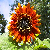

In [28]:
img


In [29]:
img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

img_label = tf.constant([[0., 0., 0., 1., 0.]]) #sunflower

test_ds = tf.data.Dataset.from_tensor_slices((img_array, img_label))
test_ds = test_ds.batch(1)


In [31]:

test_tflite_model(path_to_tflite_model, test_ds)


Tflite model test accuracy: 0.0
